This assignment will implement two different functions to compute the slope (maximum gradient) of a raster, compare their outputs, and understand the impact of raster parameters on the outputs.

In [1]:
import os
import sys
import rasterio
import math
import matplotlib.pyplot as plt
from rasterio import plot, crs
from rasterio.warp import transform_bounds, calculate_default_transform, reproject, Resampling
import numpy as np
from pyproj import CRS
from ProjectModules import PrettyTable as pt

In [30]:
def summary_dem(filename, out_epsg):
    '''This function reads in a raster file and outputs a dictionary that summarize the information zbout the input,
       and the parameter out_epsg is used to identify the transformation between lon/lat and x_utm/y_utm.''' 
    try:
        with rasterio.open(filename,'r') as src:
            summary_dict = {}
            path = src.name
            name = path.split('\\')
            summary_dict['Filename'] = name[2]
            crs = src.crs
            in_crs = CRS(crs.to_epsg())
            in_unit = in_crs.coordinate_system.axis_list[0].unit_name
            out_crs = CRS(out_epsg)
            out_unit = out_crs.coordinate_system.axis_list[0].unit_name

            summary_dict['Coordinate system'] = crs.to_epsg()
            bounds = src.bounds
            if in_unit == 'degree':
                min_lon, min_lat, max_lon, max_lat = bounds
                summary_dict['Min Lon'] = {'value': min_lon, 'units': in_unit}
                summary_dict['Min Lat'] = {'value': min_lat, 'units': in_unit}
                summary_dict['Max Lon'] = {'value': max_lon, 'units': in_unit}
                summary_dict['Max Lat'] = {'value': max_lat, 'units': in_unit}

                x_min, y_min, x_max, y_max = transform_bounds(in_crs, out_crs, min_lon, min_lat, max_lon, max_lat)
                summary_dict['Min x'] = {'value': x_min, 'units': out_unit}
                summary_dict['Min y'] = {'value': y_min, 'units': out_unit}
                summary_dict['Max x'] = {'value': x_max, 'units': out_unit}
                summary_dict['Max y'] = {'value': y_max, 'units': out_unit}    
            if in_unit == 'metre':
                x_min, y_min, x_max, y_max = bounds
                summary_dict['Min x'] = {'value': x_min, 'units': in_unit}
                summary_dict['Min y'] = {'value': y_min, 'units': in_unit}
                summary_dict['Max x'] = {'value': x_max, 'units': in_unit}
                summary_dict['Max y'] = {'value': y_max, 'units': in_unit}

                min_lon, min_lat, max_lon, max_lat = transform_bounds(in_crs, out_crs, x_min, y_min, x_max, y_max)
                summary_dict['Min Lon'] = {'value': min_lon, 'units': out_unit}
                summary_dict['Min Lat'] = {'value': min_lat, 'units': out_unit}
                summary_dict['Max Lon'] = {'value': max_lon, 'units': out_unit}
                summary_dict['Max Lat'] = {'value': max_lat, 'units': out_unit}

            width = src.width
            height = src.height
            summary_dict['Width'] = {'value': width, 'units': 'columns'}
            summary_dict['Height'] = {'value': height, 'units': 'rows'}

            cellsize_x, cellsize_y  = src.res
            summary_dict['Cell size'] = {'cellsizeX': cellsize_x, 'cellsizeY': cellsize_y, 'units': in_unit}

            summary_dict['NoData'] = src.nodata

            band = src.read(1, masked = True)  # Mask nodata pixels
            summary_dict['Min value'] = {'value': band.min(), 'units': 'metre'}
            summary_dict['Max value'] = {'value': band.max(), 'units': 'metre'}
        return summary_dict
    
    except rasterio.errors.CRSError as e1:
        print('Wrong input parameter(out_epsg): '+ str(e1))
    
    except rasterio.errors.RasterioIOError as e2:
        print('Wrong input file: '+ str(e2))
        
def display_summary(summary_dict):
    '''This function prints the values of input dictionary into a table.'''
    try:
        if type(summary_dict) != dict:
            raise ValueError
    except ValueError as reason:
        print('summary_dict must be dictionary!')
    else:
        sys.path.append('../')
        val_row1 = summary_dict['Filename']
        val_row2 = str(summary_dict['Coordinate system']) + " [EPSG]"
        val_row3 = ('%.3f'%summary_dict['Min x']['value'] +' '+ summary_dict['Min x']['units']
                    + ', ' + '%.3f'%summary_dict['Min Lon']['value'] +' '+ summary_dict['Min Lon']['units'])
        val_row4 = ('%.3f'%summary_dict['Max x']['value'] +' '+ summary_dict['Max x']['units']
                    + ', ' + '%.3f'%summary_dict['Max Lon']['value'] +' '+ summary_dict['Max Lon']['units'])
        val_row5 = ('%.3f'%summary_dict['Min y']['value'] +' '+ summary_dict['Min y']['units']
                    + ', ' + '%.3f'%summary_dict['Min Lat']['value'] +' '+ summary_dict['Min Lat']['units'])
        val_row6 = ('%.3f'%summary_dict['Max y']['value'] +' '+ summary_dict['Max y']['units']
                    + ', ' + '%.3f'%summary_dict['Max Lat']['value'] +' '+ summary_dict['Max Lat']['units'])
        val_row7 = (str(summary_dict['Width']['value']) +' '+ summary_dict['Width']['units'] 
                    + ', ' + str(summary_dict['Height']['value']) +' '+ summary_dict['Height']['units'] 
                    + ', ' + '%.6f'%summary_dict['Cell size']['cellsizeX'] + '*' + '%.6f'%summary_dict['Cell size']['cellsizeY']
                    + ' ' + summary_dict['Cell size']['units'])
        val_row8 = summary_dict['NoData']
        val_row9 = ('%.3f'%summary_dict['Min value']['value'] + ' '+ summary_dict['Min value']['units']
                    + ', ' + '%.3f'%summary_dict['Max value']['value'] +' '+ summary_dict['Max value']['units'])

        data = np.array([['Filename',val_row1],['Coordinate system', val_row2], ['Min x, Min Lon', val_row3],
                         ['Max x, Max Lon', val_row4], ['Min y, Min Lat', val_row5], ['Max y, Max Lat', val_row6],
                         ['Width, Height, Cell Size', val_row7], ['NoData', val_row8], 
                         ['Min value, Max value', val_row9]])    
        return pt.PrettyTable(data, [r"$Parameter$", r"$Value$"])

def plot_highest_value_cell(filename):
    '''This function outputs the geographic coordinates of the cell with the highest value in the dataset, and
       output a visualization of the raster with the cell highlighted.'''
    try:
        with rasterio.open(filename,'r') as src:
            if src.count != 1:
                raise ValueError
            else:
                band = src.read(1)
                max_value = band.max()
                width = src.width
                height = src.height
                heightest_cell = []
                coordinate = []
                for col in range(width):
                    for row in range(height):
                        if band[row, col] == max_value:
                            heightest_cell.append((row, col))           
                for cell in heightest_cell:
                    x_centre, y_centre = src.xy(cell[0], cell[1])
                    coordinate.append((x_centre,y_centre))

                fig, ax1 = plt.subplots(1, figsize=(9,5))
                plot.show((src,1),interpolation='none',ax=ax1)
                ax1.set_title('Figure 1. Visualization of CLIP.tif',fontsize=18)
                ax1.set_xlabel('Longitude', fontsize=14)
                ax1.set_ylabel('Latitude', fontsize=14)

                for cell in coordinate:
                    lat, lon = cell
                    ax1.plot([lat],[lon], 'ro')
                    text = ('Cell with highest value\n' + '(' + '%.5f'%lat + ','+ '%.5f'%lon + ')')
                    ax1.annotate(text, xy = cell,
                                 fontsize = 13,
                                 color = 'r',
                                 xytext = (lat-0.2, lon+0.1), arrowprops = dict(facecolor = 'black', shrink = 0.1))
                plt.show()
    except ValueError as reason:
        print('Band of input dataset over 1.')
    except rasterio.errors.RasterioIOError as reason:
        print('Wrong input file: '+ str(reason))

def reproject_DEM(filename, target_epsg):
    '''This function converts the input dataset to the target projected coordinate system.'''
    try:
        reproj_img = os.path.join(os.path.curdir,'DEM','Reproject.tif')
        out_crs = crs.CRS.from_epsg(target_epsg)

        with rasterio.open(filename,'r') as src:
            profile = src.profile

            out_transform, out_width, out_height = calculate_default_transform(
                                                            src.crs, out_crs, src.width, src.height, *src.bounds)

            profile.update({
                                'crs': out_crs,
                                'transform': out_transform,
                                'width': out_width,
                                'height': out_height,
                                'nodata': -1
                            })

            with rasterio.open(reproj_img, 'w', **profile) as reproj:
                for i in range(1, src.count + 1):
                    src_array = src.read(i)
                    reproj_array = np.empty((out_height, out_width), dtype = profile['dtype'])

                    reproject(
                                source = src_array,
                                src_crs = src.crs,
                                src_transform = src.transform,

                                destination = reproj_array,
                                dst_transform = out_transform,
                                dst_crs = out_crs,
                                dst_nodata = -1,

                                resampling = Resampling.bilinear
                                )
                    reproj.write(reproj_array, indexes=i)
                    
    except rasterio.errors.CRSError as e1:
        print('Wrong input parameter(target_epsg): '+ str(e1))
    
    except rasterio.errors.RasterioIOError as e2:
        print('Wrong input file: '+ str(e2))

def resample_DEM(filename, scale):
    '''This function resamples the input dataset, using bilinear interpolation.'''
    try:
        if type(scale) != int:
            raise ValueError
        elif scale == 0:
            raise ZeroDivisionError
        else:
            upscale_factor = (1/scale)
            output_name = 'Resample'+ '(' + str(scale) + 'x).tif'
            repsample_img = os.path.join(os.path.curdir,'DEM',output_name)

            with rasterio.open(filename, 'r+') as dataset:
                new_height = int(dataset.height * upscale_factor)
                new_width = int(dataset.width * upscale_factor)

                data = dataset.read(
                                        out_shape=(
                                                    dataset.count, 
                                                    new_height,
                                                    new_width
                                                    ),
                                        resampling=Resampling.bilinear
                                    )
                transform = dataset.transform * dataset.transform.scale(
                                                                        (dataset.width / data.shape[-1]),
                                                                        (dataset.height / data.shape[-2])
                                                                        )
                profile = dataset.profile
                profile.update(
                                transform = transform, 
                                height = new_height, 
                                width = new_width, 
                                crs = dataset.crs
                               )
                with rasterio.open(repsample_img,'w', **profile) as dst:
                    dst.write(data)
    except ValueError:
        print('Input parameter(scale) must be int!')
    except ZeroDivisionError:
        print('Input parameter(scale) can not be 0!')
    except rasterio.errors.RasterioIOError as e:
        print('Wrong input file: '+ str(e))
            
def polt_histograms(file1, file2):
    '''This function outputs the histograms of input datasets.'''
    try:
        fig1,(ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
        fig1.suptitle('Figure 2. Visualization of Resampled dataset and Histogram', fontsize=18)
        fig2,(ax3,ax4) = plt.subplots(1,2, figsize=(14,7))
        with rasterio.open(file1, 'r') as src1:
            plot.show((src1,1),cmap='Greys_r', interpolation='none',ax=ax1)
            ax1.set_title('Resample(2x).tif',fontsize=16)
            ax1.set_xlabel('X /metre', fontsize=12)
            ax1.set_ylabel('Y /metre', fontsize=12)

            plot.show_hist(src1,ax=ax3)
            ax3.set_title('Histogram of Resample(2x).tif',fontsize=16)
            ax3.set_xlim(0,1600)
        with rasterio.open(file2, 'r') as src2:
            plot.show((src2,1),cmap='Greys_r', interpolation='none',ax=ax2)
            ax2.set_title('Resample(4x).tif',fontsize=16)
            ax2.set_xlabel('X /metre', fontsize=12)
            ax2.set_ylabel('Y /metre', fontsize=12)

            plot.show_hist(src2,ax=ax4)
            ax4.set_title('Histogram of Resample(4x).tif',fontsize=16)
            ax4.set_xlim(0,1600)

        plt.show()
    except rasterio.errors.RasterioIOError as e:
        print('Wrong input file: '+ str(e))

def second_order_FD(filename):
    '''This fuction computes the slope value for the input dataset, using 2FD method.'''
    try:
        with rasterio.open(filename,'r') as dataset:
            value_dem = [0 for x in range(0, 9)]
            slope = np.zeros((dataset.height, dataset.width), dtype = np.float)
            img = dataset.read(1)
            cellsize_x, cellsize_y = dataset.res
            
            for i in range(0, dataset.height):
                for j in range(0, dataset.width):
                # Initialize a 3X3 kernel 
                # and fill the outside of the image with 0.
                    value_dem[0] = img[i][j]
                    value_dem[1] = (img[i - 1][j - 1] if (i > 1 and j > 1) else 0)
                    value_dem[2] = (img[i][j - 1] if j > 1 else 0)
                    value_dem[3] = (img[i + 1][j - 1] if (i < dataset.height - 1 and j > 1) else 0)
                    value_dem[4] = (img[i - 1][j] if i > 1 else 0)
                    value_dem[5] = (img[i + 1][j] if i < dataset.height - 1 else 0)
                    value_dem[6] = (img[i - 1][j + 1] if (i > 1 and j < dataset.width - 1) else 0)
                    value_dem[7] = (img[i][j + 1] if j < dataset.width - 1 else 0)
                    value_dem[8] = (img[i + 1][j + 1] if (i < dataset.height - 1 and j < dataset.width - 1) else 0)
                    
                # Handle nodata area：
                # Calculate the average height of this kernel(except nodata cell).
                    sum = 0.0
                    count = 0
                    for cell in value_dem:
                        if cell != -1:
                            count += 1
                            sum += cell
                # use the average to replace nodata value.
                    if count != 0:
                        average = sum/count
                        for cell in value_dem:
                            if cell == -1:
                                cell = average
                # when all cells are nodata, fill them with 0
                    elif count == 0:
                        for cell in value_dem:
                            if cell == -1:
                                cell = 0          
                # compute slope by 2FD
                    f_x = (value_dem[4]-value_dem[5])/(2*cellsize_y)
                    f_y = (value_dem[7]-value_dem[2])/(2*cellsize_x)

                    dem = math.sqrt(math.pow(f_x, 2) + math.pow(f_y, 2))

                    slope[i][j] = np.arctan(dem) * (180/math.pi)
        return slope
    except rasterio.errors.RasterioIOError as e:
        print('Wrong input file: '+ str(e))

def maximum_max(filename):
    '''This fuction computes the slope value for the input dataset, using Maximum max method.'''
    try:
        with rasterio.open(filename,'r') as dataset:
            value_dem = [0 for x in range(0, 9)]
            slope = np.zeros((dataset.height, dataset.width), dtype = np.float)
            img = dataset.read(1)
            cellsize_x = dataset.res[0]
            cellsize_y = dataset.res[1]
            cell_diagonal = math.sqrt(math.pow(cellsize_x, 2) + math.pow(cellsize_y, 2))
            for i in range(0, dataset.height):
                for j in range(0, dataset.width):
                # Initialize a 3X3 kernel(window) 
                # and fill the outside of the image with 0.
                    value_dem[0] = img[i][j]
                    value_dem[1] = (img[i - 1][j - 1] if (i > 1 and j > 1) else 0)
                    value_dem[2] = (img[i][j - 1] if j > 1 else 0)
                    value_dem[3] = (img[i + 1][j - 1] if (i < dataset.height - 1 and j > 1) else 0)
                    value_dem[4] = (img[i - 1][j] if i > 1 else 0)
                    value_dem[5] = (img[i + 1][j] if i < dataset.height - 1 else 0)
                    value_dem[6] = (img[i - 1][j + 1] if (i > 1 and j < dataset.width - 1) else 0)
                    value_dem[7] = (img[i][j + 1] if j < dataset.width - 1 else 0)
                    value_dem[8] = (img[i + 1][j + 1] if (i < dataset.height - 1 and j < dataset.width - 1) else 0)
                # Handle nodata area：
                # Calculate the average height of this kernel(except nodata cell).
                    sum = 0.0
                    count = 0
                    for cell in value_dem:
                        if cell != -1:
                            count += 1
                            sum += cell
                # use the average to replace nodata value.
                    if count != 0:
                        average = sum/count
                        for cell in value_dem:
                            if cell == -1:
                                cell = average
                # when all cells are nodata, fill them with 0
                    elif count == 0:
                        for cell in value_dem:
                            if cell == -1:
                                cell = 0 
                # compute slope by Maximum max
                    max_dem = max(abs(value_dem[0] - value_dem[1]) / cell_diagonal, abs(value_dem[0] - value_dem[2]) / cellsize_y,
                                  abs(value_dem[0] - value_dem[3]) / cell_diagonal, abs(value_dem[0] - value_dem[4]) / cellsize_x,
                                  abs(value_dem[0] - value_dem[5]) / cellsize_x, abs(value_dem[0] - value_dem[6]) / cell_diagonal,
                                  abs(value_dem[0] - value_dem[7]) / cellsize_y, abs(value_dem[0] - value_dem[8]) / cell_diagonal)

                    slope[i][j] = np.arctan(max_dem) * (180/math.pi)
        return slope
    except rasterio.errors.RasterioIOError as e:
        print('Wrong input file: '+ str(e))

def plot_slope_distribution(slope_1,slope_2,algorithms):
    '''This fuction plots the distribution of the slope values for the input algorithms.'''
    try:
        if type(algorithms) != str:
            raise ValueError
        else:
            fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,7))
            fig.suptitle(algorithms, fontsize=18)
            plot.show_hist(slope_1, bins =50, ax=ax1)
            ax1.set_title('Slope Value Distribution of Resample(2x).tif',fontsize=16)
            ax1.set_xlim(0,90)

            plot.show_hist(slope_2,bins =50,ax=ax2)
            ax2.set_title('Slope Value Distribution of Resample(4x).tif',fontsize=16)
            ax2.set_xlim(0,90)

            plt.show()
    except ValueError:
        print('Input parameter(algorithms) must be str!')

def plot_statistical_properties(slope_2x_2FD, slope_4x_2FD, slope_2x_Max, slope_4x_Max):
    '''This function plots the statistical properties(mean,median) of each input parameter.'''
    mean1 = np.mean(slope_2x_2FD)
    mean2 = np.mean(slope_4x_2FD)
    mean3 = np.mean(slope_2x_Max)
    mean4 = np.mean(slope_4x_Max)
    
    median1 = np.median(slope_2x_2FD)
    median2 = np.median(slope_4x_2FD)
    median3 = np.median(slope_2x_Max)
    median4 = np.median(slope_4x_Max)
    
    x = [1,3]
    y1 = [mean1, mean3]
    y2 = [mean2, mean4]
    y3 = [median1, median3]
    y4 = [median2, median4]
    
    fig,ax = plt.subplots(figsize=(8,5))
    fig.suptitle('Figure 5. Comparison of mean and median values ', fontsize=18)
    ax.plot(x,y1,label= 'Resample(2x).tif -- Mean', linewidth = 3, marker = 'o', markersize=8)
    ax.plot(x,y2,label= 'Resample(4x).tif -- Mean', linewidth = 3, marker = 's', markersize=8)
    ax.plot(x,y3,label= 'Resample(2x).tif -- Median', linewidth = 3, marker = '^', markersize=8)
    ax.plot(x,y4,label= 'Resample(4x).tif -- Median', linewidth = 3, marker = 'v', markersize=8)
    
    ax.set_xlabel('Algorithms',fontsize=14)
    ax.set_ylabel('Slope Value', fontsize=14)
    
    ax.set_xlim(0,4)
    ax.set_ylim(11,16.5)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['', '2FD', '', 'Max', ''], fontsize=18)
       
    ax.legend(loc='center left',bbox_to_anchor=(0.08, -0.24), ncol=2)
    
    ax.annotate('%.2f'% mean1, xy = (1,mean1),
                         fontsize = 13,
                         xytext = (0.8, mean1+0.3))
    ax.annotate('%.2f'% mean2, xy = (1,mean2),
                         fontsize = 13,
                         xytext = (0.8, mean2-0.3))
    ax.annotate('%.2f'% mean3, xy = (3,mean3),
                         fontsize = 13,
                         xytext = (3.1, mean3))
    ax.annotate('%.2f'% mean4, xy = (3,mean4),
                         fontsize = 13,
                         xytext = (3.1, mean4))
    ax.annotate('%.2f'% median1, xy = (1,median1),
                         fontsize = 13,
                         xytext = (0.8, median1+0.3))
    ax.annotate('%.2f'% median2, xy = (1, median2),
                         fontsize = 13,
                         xytext = (0.8,  median2+0.3))
    ax.annotate('%.2f'% median3, xy = (3,median3),
                         fontsize = 13,
                         xytext = (3.1, median3-0.2))
    ax.annotate('%.2f'% median4, xy = (3,median4),
                         fontsize = 13,
                         xytext = (3.1, median4-0.1))
    ax.grid()
    plt.show()

# Task 1

## Task 1.1-1.2
The following table summarizes the information about the raster data(CLIP.tif).

In [23]:
# Task 1.1
filename = os.path.join(os.path.curdir,'DEM','CLIP.tif')
summary_dict = summary_dem(filename, 3111)
# Task 1.2
display_summary(summary_dict)

$Parameter$,$Value$
Filename,CLIP.tif
Coordinate system,4326 [EPSG]
"Min x, Min Lon","2539962.688 metre, 145.455 degree"
"Max x, Max Lon","2627972.335 metre, 146.446 degree"
"Min y, Min Lat","2390417.722 metre, -37.979 degree"
"Max y, Max Lat","2451433.293 metre, -37.437 degree"
"Width, Height, Cell Size","3569 columns, 1951 rows, 0.000278*0.000278 degree"
NoData,-3.4028234663852886e+38
"Min value, Max value","70.187 metre, 1563.100 metre"


\newpage
## Task 1.4
Figure 1 shows a visualization of raster data(CLIP.tif) and highlights the cell with the highest value in the dataset, the geographic coordinates of this cell is (146.294, -37.831).

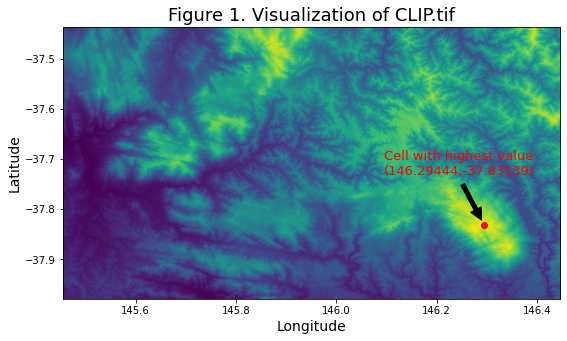

In [24]:
# Task 1.4
plot_highest_value_cell(filename)

\newpage
# Task 2 Processing a raster DEM

## Task 2.1

### Reproject
The following table summarizes the information about the reprojected raster dataset, which transfer the CRS from epsg:4326 to epsg:3111. Since the image will be distorted after reprojection, the data in the table below is slightly different from before. Besides, for the convenience of calculation, the value of Nodata is set to -1.

In [25]:
# Task 2.1
reproject_DEM(filename, 3111)
reproj_filename = os.path.join(os.path.curdir,'DEM','Reproject.tif')
reproj_summary_dict = summary_dem(reproj_filename, 4326)
display_summary(reproj_summary_dict)

$Parameter$,$Value$
Filename,Reproject.tif
Coordinate system,3111 [EPSG]
"Min x, Min Lon","2539962.688 metre, 145.452 degree"
"Max x, Max Lon","2627979.462 metre, 146.457 degree"
"Min y, Min Lat","2390416.330 metre, -37.987 degree"
"Max y, Max Lat","2451433.293 metre, -37.429 degree"
"Width, Height, Cell Size","3374 columns, 2339 rows, 26.086773*26.086773 metre"
NoData,-1.0
"Min value, Max value","70.254 metre, 1562.754 metre"


\newpage
### Resample
Figure 2 show the visualization of the datasets with cell sizes of 2x and 4x the cells size and their histograms, which resampled by bilinear interpolation.

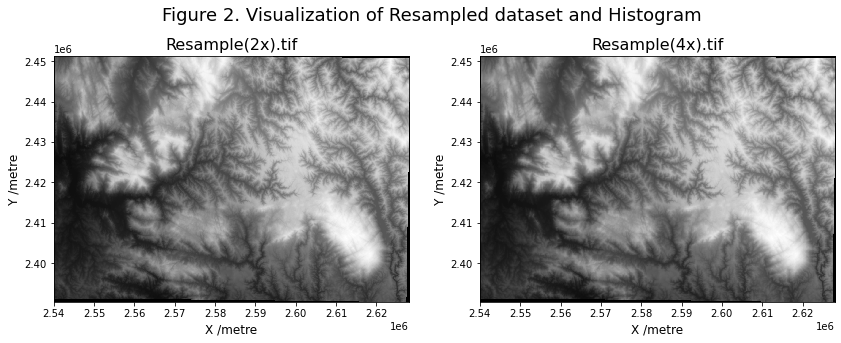

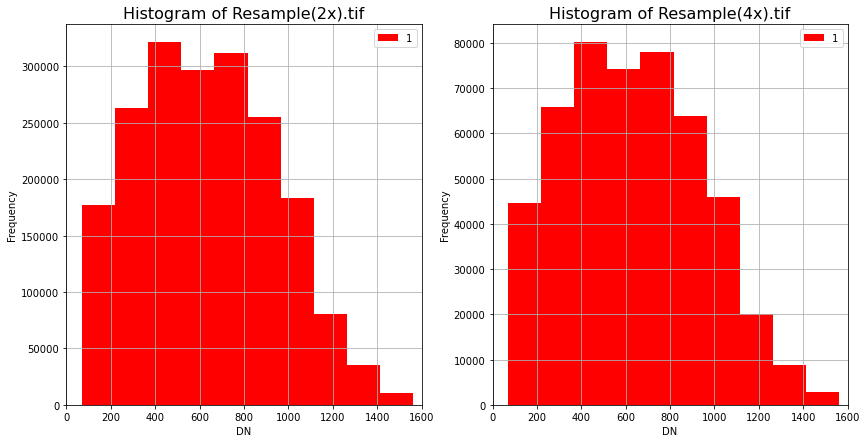

In [26]:
resample_DEM(reproj_filename, 2)
resample_1_filename = os.path.join(os.path.curdir,'DEM','Resample(2x).tif')
resample_DEM(reproj_filename, 4)
resample_2_filename = os.path.join(os.path.curdir,'DEM','Resample(4x).tif')

polt_histograms(resample_1_filename, resample_2_filename)

\newpage

The following tables summarizes the information about the resampled raster datasets.

In [27]:
resample_1_summary_dict = summary_dem(resample_1_filename, 4326)
display_summary(resample_1_summary_dict)

$Parameter$,$Value$
Filename,Resample(2x).tif
Coordinate system,3111 [EPSG]
"Min x, Min Lon","2539962.688 metre, 145.452 degree"
"Max x, Max Lon","2627979.462 metre, 146.457 degree"
"Min y, Min Lat","2390416.330 metre, -37.987 degree"
"Max y, Max Lat","2451433.293 metre, -37.429 degree"
"Width, Height, Cell Size","1687 columns, 1169 rows, 52.173547*52.195862 metre"
NoData,-1.0
"Min value, Max value","70.572 metre, 1561.288 metre"


In [28]:
resample_2_summary_dict = summary_dem(resample_2_filename, 4326)
display_summary(resample_2_summary_dict)

$Parameter$,$Value$
Filename,Resample(4x).tif
Coordinate system,3111 [EPSG]
"Min x, Min Lon","2539962.688 metre, 145.452 degree"
"Max x, Max Lon","2627979.462 metre, 146.457 degree"
"Min y, Min Lat","2390416.330 metre, -37.987 degree"
"Max y, Max Lat","2451433.293 metre, -37.429 degree"
"Width, Height, Cell Size","843 columns, 584 rows, 104.408984*104.481101 metre"
NoData,-1.0
"Min value, Max value","71.378 metre, 1559.235 metre"


\newpage
## Task 2.2-2.4
Figure 3 and Figure 4 shows the distribution of slope values computed by different algorithms. In this assignment, I choose 2FD and Maximum max to estimate the slope because these two algorithms are implemented by different ways, which are quite representative.

In [31]:
# Task 2.2
slope1 = second_order_FD(resample_1_filename)
slope2 = second_order_FD(resample_2_filename)
slope3 = maximum_max(resample_1_filename)
slope4 = maximum_max(resample_2_filename)

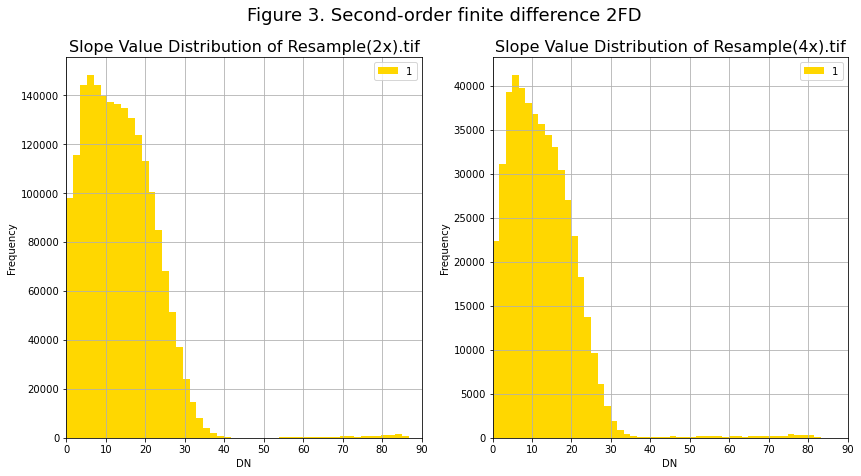

In [32]:
plot_slope_distribution(slope1,slope2,'Figure 3. Second-order finite difference 2FD')

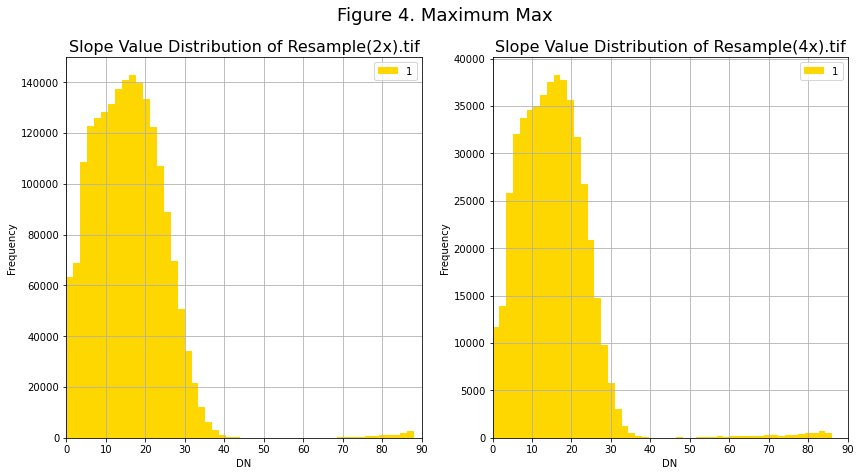

In [33]:
plot_slope_distribution(slope3,slope4,'Figure 4. Maximum Max')

By comparing the slope histograms obtained by the two algorithms, it can be seen that the distribution of slope values with different resolutions calculated by the same algorithm is approximately the same. For different algorithms, the mode of the histogram calculated by 2FD (5\~8°) is smaller than that calculated by Maximum Max(15\~18°).

\newpage

Figure 5 shows the differences in mean and median values for the different tested algorithms. 

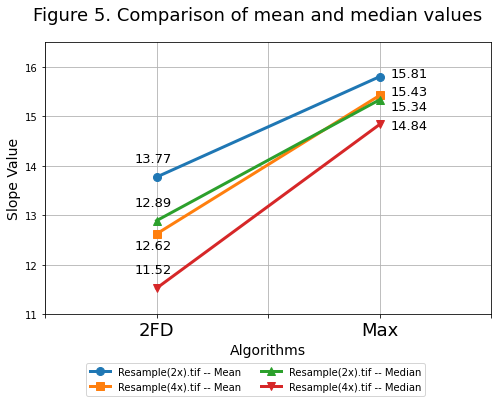

In [34]:
plot_statistical_properties(slope1,slope2,slope3,slope4)

The mean and median value comparison provides the general analysis on the difference of slope estimation algorithms, mean value is decribing the average estimated level while median value is representing the 50th percentile. Visual interpretation of Figure 5 indicates that Maximum Max methods always shows the higher mean and median values, considerably different to 2FD. Generally, the mean and median values are reflecting the whole dataset, so the comparison of them shows the differences between 2FD and Maximum max, i.e. Maximum max is overestimated compared to 2FD. However, due to no actual "true" values of slope, the accuracy of different methods can not be determined. Thus, different algorithms are most probably suitable for different applications on different scales.

***Impact of coarsening on the data***

Coarsening affects the accuracy of data and produces errors. It can be seen from the above results that the mean and median of the data set become smaller after coarsening, this is because the size and number of cells have changed during the resampling process, and after using the interpolation to assign values to the new cells, cell value will alter. Therefore, coarsening will affect the accuracy of the data. However,  coarsening reduces the number of cells in a raster dataset, so it is possible to reduce the amount of calculation and the speed of calculation when using raster data for calculation. In conclusion, within the allowable range of error, coarsening the data can improve the efficiency of the work. 